# ONNX Device Profiling Experiments (Android + Termux/ADB)

End-to-end experiments for speech fluency model deployment: dataset analysis, ONNX export, quantization (FP32/INT8), evaluation, and profiling on host + Android device.

**Run all cells sequentially from top to bottom.**

In [9]:
import json, os, re, subprocess, sys, textwrap, shutil
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def find_repo_root(start: Path) -> Path:
    start = start.resolve()
    for candidate in [start, *start.parents]:
        if (candidate / 'pyproject.toml').exists() and (candidate / 'src').exists():
            return candidate
    raise RuntimeError(f'Could not find repo root from {start}')

repo = find_repo_root(Path.cwd())
if Path.cwd().resolve() != repo:
    os.chdir(repo)
    print(f'Switched working directory to {repo}')
else:
    print(f'Running from repo root: {repo}')

exports = repo / 'experiments' / 'exports'
profiles = repo / 'experiments' / 'profiles'
results_dir = repo / 'results'
exports.mkdir(parents=True, exist_ok=True)
profiles.mkdir(parents=True, exist_ok=True)
results_dir.mkdir(parents=True, exist_ok=True)

def ensure_adb_on_path():
    if shutil.which('adb'):
        print('adb found on PATH')
        return
    candidates = []
    for env_key in ('ANDROID_HOME','ANDROID_SDK_ROOT'):
        root = os.environ.get(env_key)
        if root:
            candidates.append(Path(root)/'platform-tools'/'adb')
    candidates.append(Path.home()/'Library/Android/sdk/platform-tools/adb')
    candidates.append(Path.home()/'Android/Sdk/platform-tools/adb')
    for cand in candidates:
        if cand.exists():
            os.environ['PATH'] = '{}:{}'.format(cand.parent, os.environ['PATH'])
            print(f'Added {cand.parent} to PATH for adb')
            return
    print('Warning: adb not found. Install Android platform-tools or set PATH manually.')
ensure_adb_on_path()
print('Repo path set to:', repo)


Running from repo root: /Users/zhantore/Documents/study/csci447/csci447-final-project
adb found on PATH
Repo path set to: /Users/zhantore/Documents/study/csci447/csci447-final-project


## 0) Dataset Analysis and Visualization

In [10]:
# Load and analyze dataset
manifest_path = repo / 'experiments' / 'speechocean_manifest.csv'
df_dataset = pd.read_csv(manifest_path)

print(f"Dataset size: {len(df_dataset)} samples")
print(f"\nSplit distribution:")
print(df_dataset['split'].value_counts())
print(f"\nLabel distribution:")
print(df_dataset['label'].value_counts())
print(f"\nSpeakers: {df_dataset['speaker_id'].nunique()}")

df_dataset.head()

Dataset size: 5000 samples

Split distribution:
split
train    2500
test     2500
Name: count, dtype: int64

Label distribution:
label
moderate    2953
poor        1121
good         926
Name: count, dtype: int64

Speakers: 250


,path,duration,text,speaker_id,label,split
0,/Users/zhantore/Documents/study/csci447/csci44...,NaN,WE CALL IT BEAR,1,moderate,train
1,/Users/zhantore/Documents/study/csci447/csci44...,NaN,ZERO THREE FIVE ONE,1,moderate,train
2,/Users/zhantore/Documents/study/csci447/csci44...,NaN,THREE TWO TWO SEVEN,1,good,train
3,/Users/zhantore/Documents/study/csci447/csci44...,NaN,ELEPHANTS TAI GOOSE,1,good,train
4,/Users/zhantore/Documents/study/csci447/csci44...,NaN,TOM GIVES UP BOXING,1,good,train


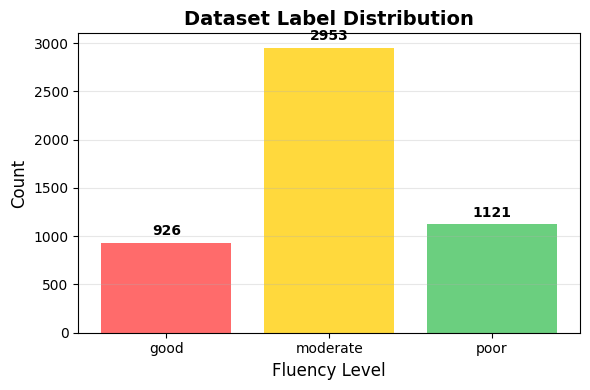


Label percentages:
  good: 926 (18.5%)
  moderate: 2953 (59.1%)
  poor: 1121 (22.4%)


In [11]:

fig, ax = plt.subplots(figsize=(6, 4))

# Overall label distribution
label_counts = df_dataset['label'].value_counts().sort_index()
ax.bar(label_counts.index, label_counts.values, color=['#ff6b6b', '#ffd93d', '#6bcf7f'])
ax.set_xlabel('Fluency Level', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Dataset Label Distribution', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, (label, count) in enumerate(label_counts.items()):
    ax.text(i, count + 50, str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(results_dir / 'dataset_label_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Print label percentages
print(f"\nLabel percentages:")
for label, count in label_counts.items():
    pct = (count / len(df_dataset)) * 100
    print(f"  {label}: {count} ({pct:.1f}%)")


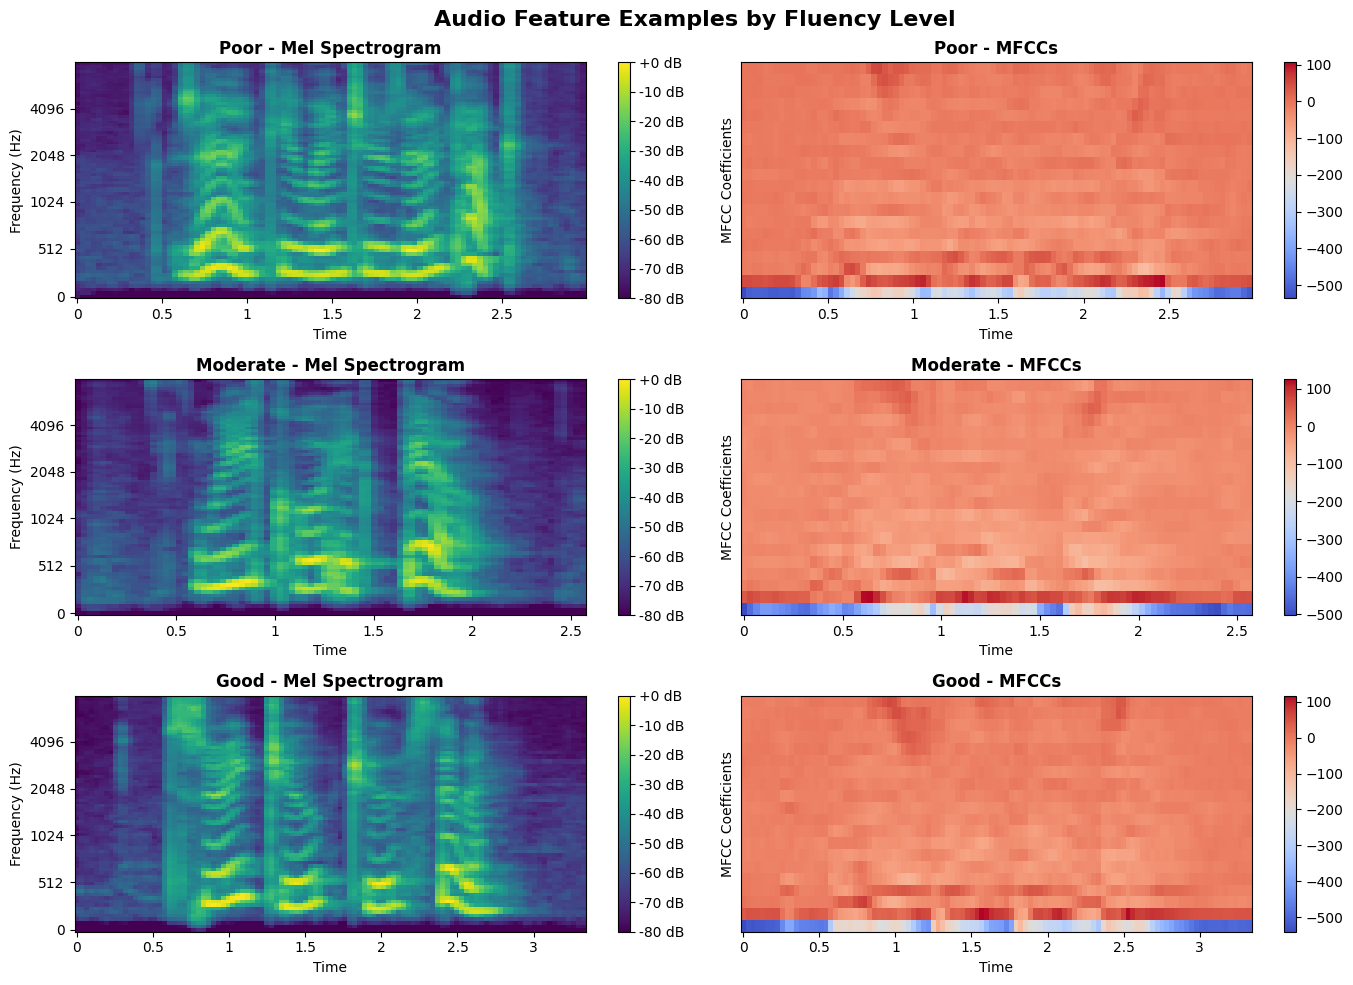

In [12]:
# 2. Example Spectrogram/MFCC Visualization
import librosa
import librosa.display
import soundfile as sf

# Select one example from each class
examples = {}
for label in ['poor', 'moderate', 'good']:
    sample = df_dataset[df_dataset['label'] == label].iloc[0]
    examples[label] = sample['path']

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
fig.suptitle('Audio Feature Examples by Fluency Level', fontsize=16, fontweight='bold')

for idx, (label, audio_path) in enumerate(examples.items()):
    # Load audio
    y, sr = librosa.load(audio_path, sr=16000)
    
    # Compute mel spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=80, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    
    # Plot mel spectrogram
    img1 = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, 
                                        fmax=8000, ax=axes[idx, 0], cmap='viridis')
    axes[idx, 0].set_title(f'{label.capitalize()} - Mel Spectrogram', fontweight='bold')
    axes[idx, 0].set_ylabel('Frequency (Hz)')
    fig.colorbar(img1, ax=axes[idx, 0], format='%+2.0f dB')
    
    # Plot MFCCs
    img2 = librosa.display.specshow(mfccs, x_axis='time', sr=sr, ax=axes[idx, 1], cmap='coolwarm')
    axes[idx, 1].set_title(f'{label.capitalize()} - MFCCs', fontweight='bold')
    axes[idx, 1].set_ylabel('MFCC Coefficients')
    fig.colorbar(img2, ax=axes[idx, 1])

plt.tight_layout()
plt.savefig(results_dir / 'audio_features_examples.png', dpi=150, bbox_inches='tight')
plt.show()

## 1) Export ONNX

## 1.5) Generate Quantized Models

In [13]:
# Run quantization to generate INT8/dynamic quantized models
print('Running quantization (this may take a few minutes)...')
cmd = ['bash', '-lc', 'make quantize']
res = subprocess.run(cmd, cwd=repo, capture_output=True, text=True)
print(res.stdout)
if res.returncode != 0:
    print("STDERR:", res.stderr)
    print("Warning: Quantization may have encountered issues")
else:
    print("✓ Quantization completed successfully")

# Check generated quantized models
quantized_dir = repo / 'experiments' / 'quantized'
if quantized_dir.exists():
    print(f"\nGenerated quantized models:")
    for f in sorted(quantized_dir.glob('*.pt')):
        size_mb = f.stat().st_size / (1024**2)
        print(f"  {f.name}: {size_mb:.2f} MB")
    
    # Load quantization summary
    quant_summary_path = quantized_dir / 'summary.json'
    if quant_summary_path.exists():
        quant_summary = json.loads(quant_summary_path.read_text())
        print("\nQuantization Summary:")
        print(json.dumps(quant_summary, indent=2))
    else:
        quant_summary = None
else:
    print("Warning: Quantized models directory not found")
    quant_summary = None

Running quantization (this may take a few minutes)...
python -m src.quantize --config config/default.yaml --output-dir ./experiments
[11/17/25 19:27:39] INFO     Saved dynamic quantized model to                   
                             experiments/quantized/model_dynamic.pt             
[11/17/25 19:29:33] INFO     Quantization summary saved to                      
                             experiments/quantized/summary.json                 

✓ Quantization completed successfully

Generated quantized models:
  model_dynamic.pt: 3.68 MB
  model_pruned.pt: 14.68 MB
  model_static.pt: 3.68 MB

Quantization Summary:
{
  "fp32": {
    "size_mb": 14.684308052062988,
    "accuracy": 0.448,
    "macro_f1": 0.3893894894172347
  },
  "dynamic": {
    "size_mb": 3.6754322052001953,
    "accuracy": 0.452,
    "macro_f1": 0.3981605878157602,
    "accuracy_drop": -0.0040000000000000036
  },
  "static": {
    "size_mb": 3.6758480072021484,
    "accuracy": 0.448,
    "macro_f1": 0.394497342

## 1.6) Export Quantized Models to ONNX

In [14]:
# Export quantized models to ONNX format for deployment
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

quantized_onnx_dir = exports.parent / 'quantized_onnx'
quantized_onnx_dir.mkdir(parents=True, exist_ok=True)

# Quantize the FP32 ONNX model using ONNX Runtime
fp32_onnx_path = exports / 'model.onnx'
if fp32_onnx_path.exists():
    print(f"Converting FP32 ONNX to INT8 (dynamic quantization)...")
    
    # Dynamic quantization (INT8)
    int8_path = quantized_onnx_dir / 'model_int8.onnx'
    quantize_dynamic(
        model_input=str(fp32_onnx_path),
        model_output=str(int8_path),
        weight_type=QuantType.QUInt8,
    )
    int8_size = int8_path.stat().st_size / (1024**2)
    fp32_size = fp32_onnx_path.stat().st_size / (1024**2)
    if (fp32_onnx_path.parent / 'model.onnx.data').exists():
        fp32_size += (fp32_onnx_path.parent / 'model.onnx.data').stat().st_size / (1024**2)
    
    print(f"✓ INT8 ONNX model saved: {int8_path.name}")
    print(f"  FP32 size: {fp32_size:.2f} MB")
    print(f"  INT8 size: {int8_size:.2f} MB")
    print(f"  Size reduction: {(1 - int8_size/fp32_size)*100:.1f}%")
    
    # Verify the model
    onnx_model = onnx.load(str(int8_path))
    onnx.checker.check_model(onnx_model)
    print("  ✓ Model verification passed")
else:
    print("FP32 ONNX model not found. Run export first.")
    int8_path = None

# List all quantized ONNX models
print(f"\nQuantized ONNX models in {quantized_onnx_dir}:")
for f in sorted(quantized_onnx_dir.glob('*.onnx')):
    size_mb = f.stat().st_size / (1024**2)
    print(f"  {f.name}: {size_mb:.2f} MB")

Converting FP32 ONNX to INT8 (dynamic quantization)...
✓ INT8 ONNX model saved: model_int8.onnx
  FP32 size: 29.39 MB
  INT8 size: 3.68 MB
  Size reduction: 87.5%
  ✓ Model verification passed

Quantized ONNX models in /Users/zhantore/Documents/study/csci447/csci447-final-project/experiments/quantized_onnx:
  model_int8.onnx: 3.68 MB


## 1.7) Evaluate Quantized Models

In [15]:
# Evaluate quantized models using ONNX Runtime
import onnxruntime as ort

def evaluate_onnx_model(onnx_path, data_loader, label_map):
    """Evaluate an ONNX model and return accuracy metrics"""
    session = ort.InferenceSession(str(onnx_path), providers=['CPUExecutionProvider'])
    input_name = session.get_inputs()[0].name
    
    all_preds = []
    all_targets = []
    
    for batch in data_loader:
        features = batch['features'].numpy()
        labels = batch['label'].numpy()
        
        # Run inference
        outputs = session.run(None, {input_name: features})
        logits = outputs[0]
        preds = np.argmax(logits, axis=1)
        
        all_preds.extend(preds.tolist())
        all_targets.extend(labels.tolist())
    
    # Calculate accuracy
    correct = sum([p == t for p, t in zip(all_preds, all_targets)])
    accuracy = correct / len(all_targets)
    
    # Calculate per-class metrics
    from sklearn.metrics import precision_recall_fscore_support, accuracy_score
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_targets, all_preds, average='macro', zero_division=0
    )
    
    return {
        'accuracy': accuracy,
        'macro_f1': f1,
        'precision': precision,
        'recall': recall
    }

# Load data for evaluation
print("Loading validation data for evaluation...")

Loading validation data for evaluation...


In [16]:

from data.data_module import DataModule
from utils.config import parse_label_schema
import yaml

with open(repo / 'config' / 'default.yaml') as f:
    cfg = yaml.safe_load(f)

label_map = cfg['data'].get('label_map') or parse_label_schema(cfg['data'].get('label_schema', '3class'))
data_module = DataModule(cfg['data'], cfg['features'], cfg.get('augmentation', {}), label_map)
valid_loader = data_module.valid_dataloader(batch_size=32)

print(f"✓ Loaded {len(valid_loader.dataset)} validation samples")

# Evaluate FP32 ONNX model
print("\nEvaluating models on validation set...")
evaluation_results = {}

fp32_onnx = exports / 'model.onnx'
if fp32_onnx.exists():
    print("  Evaluating FP32 ONNX...")
    fp32_metrics = evaluate_onnx_model(fp32_onnx, valid_loader, label_map)
    if fp32_metrics:
        evaluation_results['fp32_onnx'] = fp32_metrics
        print(f"    Accuracy: {fp32_metrics['accuracy']:.4f}, Macro-F1: {fp32_metrics['macro_f1']:.4f}")

# Evaluate INT8 ONNX model
if int8_path and int8_path.exists():
    print("  Evaluating INT8 ONNX...")
    int8_metrics = evaluate_onnx_model(int8_path, valid_loader, label_map)
    if int8_metrics:
        evaluation_results['int8_onnx'] = int8_metrics
        acc_drop = (fp32_metrics['accuracy'] - int8_metrics['accuracy']) * 100
        print(f"    Accuracy: {int8_metrics['accuracy']:.4f}, Macro-F1: {int8_metrics['macro_f1']:.4f}")
        print(f"    Accuracy drop: {acc_drop:.2f}%")

print("\n✓ Evaluation complete")

✓ Loaded 250 validation samples

Evaluating models on validation set...
  Evaluating FP32 ONNX...
    Accuracy: 0.4480, Macro-F1: 0.3894
  Evaluating INT8 ONNX...
    Accuracy: 0.4520, Macro-F1: 0.3982
    Accuracy drop: -0.40%

✓ Evaluation complete


## 1.8) Profile Quantized Models (Host)

In [18]:
# Profile quantized models on host for latency and memory usage
import time
import psutil
import os

def profile_onnx_host(onnx_path, num_runs=25, warmup=5):
    """Profile ONNX model on host CPU"""
    import onnxruntime as ort
    
    # Create session
    session = ort.InferenceSession(str(onnx_path), providers=['CPUExecutionProvider'])
    input_name = session.get_inputs()[0].name
    input_shape = session.get_inputs()[0].shape
    
    # Replace symbolic dimensions with concrete values
    concrete_shape = []
    for dim in input_shape:
        if isinstance(dim, str):
            # Use 1 for batch dimensions, reasonable defaults for others
            concrete_shape.append(1 if 'batch' in dim.lower() else 128)
        else:
            concrete_shape.append(dim)
    
    # Create dummy input
    dummy_input = np.random.randn(*concrete_shape).astype(np.float32)
    
    # Warmup
    for _ in range(warmup):
        session.run(None, {input_name: dummy_input})
    
    # Measure latency
    latencies = []
    process = psutil.Process(os.getpid())
    mem_before = process.memory_info().rss / (1024**2)  # MB
    
    for _ in range(num_runs):
        start = time.perf_counter()
        session.run(None, {input_name: dummy_input})
        end = time.perf_counter()
        latencies.append((end - start) * 1000)  # Convert to ms
    
    mem_after = process.memory_info().rss / (1024**2)  # MB
    
    return {
        'avg_latency_ms': np.mean(latencies),
        'std_latency_ms': np.std(latencies),
        'min_latency_ms': np.min(latencies),
        'max_latency_ms': np.max(latencies),
        'p50_latency_ms': np.percentile(latencies, 50),
        'p95_latency_ms': np.percentile(latencies, 95),
        'p99_latency_ms': np.percentile(latencies, 99),
        'memory_mb': mem_after - mem_before,
        'total_memory_mb': mem_after
    }

print("Profiling models on host CPU...\n")

# Profile FP32 model
host_profile_results = {}

# Check if exports path is defined
if 'exports' not in globals():
    print("⚠️  Error: 'exports' path not defined. Make sure to run Section 0 (Setup) first.")
    fp32_onnx = None
else:
    fp32_onnx = exports / 'model.onnx'

if fp32_onnx and fp32_onnx.exists():
    print("  Profiling FP32 ONNX...")
    fp32_profile = profile_onnx_host(fp32_onnx, num_runs=25, warmup=5)
    if fp32_profile:
        host_profile_results['fp32_onnx'] = fp32_profile
        print(f"    ✓ Avg latency: {fp32_profile['avg_latency_ms']:.3f} ms")
        print(f"    ✓ P95 latency: {fp32_profile['p95_latency_ms']:.3f} ms")
        print(f"    ✓ Memory: {fp32_profile['total_memory_mb']:.2f} MB")
else:
    print("  ⚠️  FP32 ONNX model not found. Skipping FP32 profiling.")

# Profile INT8 model
if 'int8_path' in globals() and int8_path and int8_path.exists():
    print("\n  Profiling INT8 ONNX...")
    int8_profile = profile_onnx_host(int8_path, num_runs=25, warmup=5)
    if int8_profile:
        host_profile_results['int8_onnx'] = int8_profile
        print(f"    ✓ Avg latency: {int8_profile['avg_latency_ms']:.3f} ms")
        print(f"    ✓ P95 latency: {int8_profile['p95_latency_ms']:.3f} ms")
        print(f"    ✓ Memory: {int8_profile['total_memory_mb']:.2f} MB")
        
        if 'fp32_onnx' in host_profile_results:
            speedup = fp32_profile['avg_latency_ms'] / int8_profile['avg_latency_ms']
            mem_reduction = (1 - int8_profile['total_memory_mb'] / fp32_profile['total_memory_mb']) * 100
            print(f"\n    📊 Speedup: {speedup:.2f}x")
            print(f"    📊 Memory reduction: {mem_reduction:.1f}%")
else:
    print("\n  ⚠️  INT8 model not available. Make sure to run Section 1.6 first.")

print("\n✓ Host profiling complete")

Profiling models on host CPU...

  Profiling FP32 ONNX...
    ✓ Avg latency: 0.151 ms
    ✓ P95 latency: 0.218 ms
    ✓ Memory: 651.27 MB

  Profiling INT8 ONNX...
    ✓ Avg latency: 0.052 ms
    ✓ P95 latency: 0.061 ms
    ✓ Memory: 651.38 MB

    📊 Speedup: 2.92x
    📊 Memory reduction: -0.0%

✓ Host profiling complete


## 1.9) Profile Quantized Models (Android)

In [19]:
# Profile both FP32 and INT8 models on Android device via ADB
android_profile_results = {}

# Define parse_perf function if not already defined
if 'parse_perf' not in globals():
    def parse_perf(text: str):
        """Parse ONNX Runtime perf test output"""
        out = {}
        m = re.search(r'Average inference time cost total:\s*([\d.]+)\s*ms', text)
        if m: out['avg_ms'] = float(m.group(1))
        for k in ['P50','P90','P95','P99']:
            m = re.search(rf'{k}\s+Latency:\s*([\d.]+)\s*s', text)
            if m: out[k.lower()+'_ms'] = float(m.group(1))*1000.0
        return out

# First, profile FP32 model on Android
if 'exports' in globals() and (exports / 'model.onnx').exists():
    print('Profiling FP32 ONNX model on Android device...')
    print('='*60)

    # Check device connection
    device_check = subprocess.run(['bash', '-lc', 'adb devices'],
                                  capture_output=True, text=True)
    print(device_check.stdout)

    if 'device' not in device_check.stdout:
        print("⚠️  No Android device detected. Skipping Android profiling.")
        print("   Connect an Android device via ADB to enable profiling.\n")
    else:
        # Set environment for FP32 model
        env = os.environ.copy()
        env['ONNX'] = str(exports / 'model.onnx')
        env['RUNS'] = '100'
        env['THREADS'] = '4'
        env['EXTRA'] = '-S 1'  # deterministic random input

        # Run ADB benchmark for FP32
        cmd = ['bash', '-lc', './scripts/adb_benchmark_onnx.sh']
        print(f'Running: {cmd[-1]} with ONNX=model.onnx (FP32)')

        result = subprocess.run(cmd, cwd=repo, env=env, capture_output=True, text=True)

        # Save FP32 profiling output
        fp32_log_path = profiles / 'adb_ort_perf.txt'
        fp32_log_path.write_text(result.stdout)

        print(result.stdout)

        if result.returncode != 0:
            print("STDERR:", result.stderr)
            print("⚠️  FP32 Android profiling may have encountered issues")
        else:
            # Parse FP32 results
            fp32_adb_metrics = parse_perf(result.stdout)
            android_profile_results['fp32_onnx'] = fp32_adb_metrics

            print('\n' + '='*60)
            print('FP32 Android Profiling Results:')
            print('='*60)
            print(f"  Avg latency: {fp32_adb_metrics.get('avg_ms', 'N/A'):.3f} ms")
            print(f"  P50: {fp32_adb_metrics.get('p50_ms', 'N/A'):.3f} ms")
            print(f"  P90: {fp32_adb_metrics.get('p90_ms', 'N/A'):.3f} ms")
            print(f"  P95: {fp32_adb_metrics.get('p95_ms', 'N/A'):.3f} ms")
            print(f"  P99: {fp32_adb_metrics.get('p99_ms', 'N/A'):.3f} ms")
            print('='*60)
            print(f"✓ FP32 Android profiling log saved to: {fp32_log_path}\n")
else:
    print("⚠️  FP32 model not found. Skipping FP32 Android profiling.\n")

# Now profile INT8 model on Android
if 'int8_path' in globals() and int8_path and int8_path.exists():
    print('Profiling INT8 ONNX model on Android device...')
    print('='*60)
    
    # Check device connection
    device_check = subprocess.run(['bash', '-lc', 'adb devices'], 
                                  capture_output=True, text=True)
    print(device_check.stdout)
    
    if 'device' not in device_check.stdout:
        print("⚠️  No Android device detected. Skipping Android profiling for INT8.")
        int8_adb_metrics = None
    else:
        # Set environment for INT8 model
        env = os.environ.copy()
        env['ONNX'] = str(int8_path)
        env['RUNS'] = '100'
        env['THREADS'] = '4'
        env['EXTRA'] = '-S 1'  # deterministic random input
        
        # Run ADB benchmark
        cmd = ['bash', '-lc', './scripts/adb_benchmark_onnx.sh']
        print(f'Running: {cmd[-1]} with ONNX={int8_path.name}')
        
        result = subprocess.run(cmd, cwd=repo, env=env, capture_output=True, text=True)
        
        # Save INT8 profiling output
        int8_log_path = profiles / 'adb_ort_perf_int8.txt'
        int8_log_path.write_text(result.stdout)
        
        print(result.stdout)
        
        if result.returncode != 0:
            print("STDERR:", result.stderr)
            print("⚠️  INT8 Android profiling may have encountered issues")
            int8_adb_metrics = None
        else:
            # Parse INT8 results
            int8_adb_text = result.stdout
            int8_adb_metrics = parse_perf(int8_adb_text)
            android_profile_results['int8_onnx'] = int8_adb_metrics
            
            print('\n' + '='*60)
            print('INT8 Android Profiling Results:')
            print('='*60)
            print(f"  Avg latency: {int8_adb_metrics.get('avg_ms', 'N/A'):.3f} ms")
            print(f"  P50: {int8_adb_metrics.get('p50_ms', 'N/A'):.3f} ms")
            print(f"  P90: {int8_adb_metrics.get('p90_ms', 'N/A'):.3f} ms")
            print(f"  P95: {int8_adb_metrics.get('p95_ms', 'N/A'):.3f} ms")
            print(f"  P99: {int8_adb_metrics.get('p99_ms', 'N/A'):.3f} ms")
            
            # Compare with FP32
            if 'fp32_onnx' in android_profile_results:
                fp32_avg = android_profile_results['fp32_onnx'].get('avg_ms', 0)
                int8_avg = int8_adb_metrics.get('avg_ms', 0)
                if fp32_avg > 0 and int8_avg > 0:
                    speedup = fp32_avg / int8_avg
                    improvement = (1 - int8_avg / fp32_avg) * 100
                    print(f"\n  📊 Speedup vs FP32: {speedup:.2f}x ({improvement:.1f}% faster)")
            
            print('='*60)
            print(f"✓ INT8 Android profiling log saved to: {int8_log_path}")
else:
    print("⚠️  INT8 model not available for Android profiling")
    print("   Make sure to run Section 1.6 (Export Quantized Models to ONNX) first.")
    int8_adb_metrics = None

print("\n✓ Android profiling for quantized models complete")

Profiling FP32 ONNX model on Android device...
List of devices attached
adb-R52T905ND5T-v3Epcv._adb-tls-connect._tcp	device


Running: ./scripts/adb_benchmark_onnx.sh with ONNX=model.onnx (FP32)
[adb] Pushing model and perf binary...
[adb] Detected external data file; pushing /Users/zhantore/Documents/study/csci447/csci447-final-project/experiments/exports/model.onnx.data ...
[adb] Pushing ONNX Runtime shared libraries from /Users/zhantore/Documents/study/csci447/csci447-final-project/onnxruntime/build/android-arm64/Release...
[adb] Running onnxruntime_perf_test for 100 runs (auto-generated inputs)...
Setting intra_op_num_threads to 4
Session creation time cost: 0.0529972 s
First inference time cost: 2 ms
Total inference time cost: 0.170422 s
Total inference requests: 100
Average inference time cost total: 1.704220 ms
Total inference run time: 0.170626 s
Number of inferences per second: 586.079 
Avg CPU usage: 97 %
Peak working set size: 53612544 bytes
Avg CPU usage:97
Peak working set

In [20]:
# Robust ONNX export: try Makefile target if available; fallback to direct module call.
from pathlib import Path
import subprocess, sys
mf = (repo / 'Makefile')
use_make = mf.exists() and 'export_onnx:' in mf.read_text()
if use_make:
    cmd = ['bash', 'cd']
    cmd = ['bash','-lc','make export_onnx']
    print('Running Make target: make export_onnx')
else:
    cmd = [sys.executable, '-m', 'src.export_onnx', '--config', 'config/default.yaml', '--output-dir', 'experiments']
    print('Running direct module export: python -m src.export_onnx ...')
res = subprocess.run(cmd, cwd=repo, capture_output=True, text=True)
print(res.stdout)
if res.returncode != 0:
    print(res.stderr)
    raise RuntimeError('Export failed')
print('Export completed.')

Running Make target: make export_onnx
python -m src.export_onnx --config config/default.yaml --output-dir ./experiments
[11/17/25 19:33:20] INFO     Saved ONNX model to experiments/exports/model.onnx 
                    INFO     ONNX max deviation: 0.000015                       
                    INFO     Export summary saved to                            
                             experiments/exports/summary.json                   

Export completed.


In [21]:
summary_path = exports / 'summary.json'
summary = json.loads(summary_path.read_text())
summary

{'freq': 60,
 'frames': 500,
 'input_dim': 30000,
 'label_map_path': 'experiments/exports/label_map.json',
 'onnx_path': 'experiments/exports/model.onnx',
 'onnx_delta': 1.52587890625e-05}

## 2) Host profiling (ONNX)

In [22]:
# Profiles ONNX on the host and writes results into experiments/profiles/{profile.csv, summary.json}.
cmd = ['bash','-lc','TARGET_DEVICE=android_tablet make profile']
print('Running:', ' '.join(cmd[2:]))
_ = subprocess.run(cmd, cwd=repo, check=False)
host_summary_path = profiles / 'summary.json'
host_results = json.loads(host_summary_path.read_text()) if host_summary_path.exists() else []
host_results

Running: TARGET_DEVICE=android_tablet make profile
python -m src.profile_device --config config/default.yaml --output-dir ./experiments --target-device android_tablet
[11/17/25 19:33:37] INFO     Profile saved to experiments/profiles/profile.csv  
[11/17/25 19:33:38] WARNING  Unable to pull Android metrics: Command '['adb',   
                             'shell', 'run-as', 'com.example.fluencyscorer',    
                             'cat', 'files/metrics/latest.json']' returned      
                             non-zero exit status 1.                            


[{'latency_ms': 0.8511166856624186,
  'std_ms': 0.8489363721808955,
  'model': 'onnx',
  'memory_mb': 312.1875,
  'energy_proxy': 1.0213400227949023}]

## 3) Android device profiling via ADB

In [23]:
# Ensure a device is attached
print(subprocess.run(['bash','-lc','adb devices'], capture_output=True, text=True).stdout)

# Run the robust ADB helper. It auto-detects the perf binary under ./onnxruntime/,
# pushes model + libs, tries -I first, and falls back to a test_data_set_0 if needed.
env = os.environ.copy()
env['ONNX'] = str(exports / 'model.onnx')
env.setdefault('RUNS', '100')
env.setdefault('THREADS', '4')
env.setdefault('EXTRA', '-S 1')  # deterministic random input
cmd = ['bash','-lc','./scripts/adb_benchmark_onnx.sh']
print('Running ADB helper...')
_ = subprocess.run(cmd, cwd=repo, env=env, check=False)
print('ADB profiling finished. Log at', profiles / 'adb_ort_perf.txt')

List of devices attached
adb-R52T905ND5T-v3Epcv._adb-tls-connect._tcp	device


Running ADB helper...
[adb] Pushing model and perf binary...


/Users/zhantore/Documents/study/csci447/csci447-final-project/experiments/exports/model.onnx: 1 file pushed, 0 skipped. 22.3 MB/s (15395406 bytes in 0.660s)


[adb] Detected external data file; pushing /Users/zhantore/Documents/study/csci447/csci447-final-project/experiments/exports/model.onnx.data ...


/Users/zhantore/Documents/study/csci447/csci447-final-project/experiments/exports/model.onnx.data: 1 file pushed, 0 skipped. 22.9 MB/s (15425536 bytes in 0.641s)
onnxruntime/build/android-arm64/Release/onnxruntime_perf_test: 1 file pushed, 0 skipped. 80.9 MB/s (30589512 bytes in 0.360s)


[adb] Pushing ONNX Runtime shared libraries from /Users/zhantore/Documents/study/csci447/csci447-final-project/onnxruntime/build/android-arm64/Release...
[adb] Running onnxruntime_perf_test for 100 runs (auto-generated inputs)...


/Users/zhantore/Documents/study/csci447/csci447-final-project/onnxruntime/build/android-arm64/Release/libcustom_op_get_const_input_test_library.so: 1 file pushed, 0 skipped. 106.9 MB/s (350304 bytes in 0.003s)
/Users/zhantore/Documents/study/csci447/csci447-final-project/onnxruntime/build/android-arm64/Release/libcustom_op_invalid_library.so: 1 file pushed, 0 skipped. 22.7 MB/s (5512 bytes in 0.000s)
/Users/zhantore/Documents/study/csci447/csci447-final-project/onnxruntime/build/android-arm64/Release/libcustom_op_library.so: 1 file pushed, 0 skipped. 210.0 MB/s (554600 bytes in 0.003s)
/Users/zhantore/Documents/study/csci447/csci447-final-project/onnxruntime/build/android-arm64/Release/libcustom_op_local_function.so: 1 file pushed, 0 skipped. 191.8 MB/s (359384 bytes in 0.002s)
4 files pushed, 0 skipped. 15.9 MB/s (1269800 bytes in 0.076s)


Setting intra_op_num_threads to 4
Session creation time cost: 0.0647242 s
First inference time cost: 2 ms
Total inference time cost: 0.505877 s
Total inference requests: 100
Average inference time cost total: 5.058770 ms
Total inference run time: 0.506106 s
Number of inferences per second: 197.587 
Avg CPU usage: 42 %
Peak working set size: 53731328 bytes
Avg CPU usage:42
Peak working set size:53731328
Runs:100
Min Latency: 0.00157703 s
Max Latency: 0.141608 s
P50 Latency: 0.00204911 s
P90 Latency: 0.00285062 s
P95 Latency: 0.00862135 s
P99 Latency: 0.141608 s
P999 Latency: 0.141608 s
\nSaved raw output to experiments/profiles/adb_ort_perf.txt
avg_ms: ms
p50_s: 0.00204911
p90_s: 0.00285062
p95_s: 0.00862135
p99_s: 0.141608
ADB profiling finished. Log at /Users/zhantore/Documents/study/csci447/csci447-final-project/experiments/profiles/adb_ort_perf.txt


In [24]:
# Parse adb_ort_perf.txt for latency stats
log_path = profiles / 'adb_ort_perf.txt'
adb_text = log_path.read_text() if log_path.exists() else ''
def parse_perf(text: str):
    out = {}
    m = re.search(r'Average inference time cost total:\s*([\d.]+)\s*ms', text)
    if m: out['avg_ms'] = float(m.group(1))
    for k in ['P50','P90','P95','P99']:
        m = re.search(rf'{k}\s+Latency:\s*([\d.]+)\s*s', text)
        if m: out[k.lower()+'_ms'] = float(m.group(1))*1000.0
    return out
adb_metrics = parse_perf(adb_text)
adb_metrics

{'avg_ms': 5.05877,
 'p50_ms': 2.0491099999999998,
 'p90_ms': 2.8506199999999997,
 'p95_ms': 8.62135,
 'p99_ms': 141.608}

## 4) Compare and visualize

## 3.5) Model Variants Analysis (FP32 vs Quantized)

In [25]:
# Collect model size and accuracy metrics
model_variants = []

# Check if required variables exist
if 'exports' not in globals():
    print("⚠️  Error: Required variables not defined. Run all previous cells first.")
else:
    # FP32 model (ONNX)
    fp32_onnx = exports / 'model.onnx'
    fp32_data = exports / 'model.onnx.data'
    fp32_size_mb = 0
    if fp32_onnx.exists():
        fp32_size_mb += fp32_onnx.stat().st_size / (1024**2)
    if fp32_data.exists():
        fp32_size_mb += fp32_data.stat().st_size / (1024**2)

    # Load test accuracy if available
    test_accuracy_fp32 = None
    if (repo / 'experiments' / 'results.json').exists():
        results_json = json.loads((repo / 'experiments' / 'results.json').read_text())
        test_accuracy_fp32 = results_json.get('test_accuracy')

    # Use evaluation results if available
    evaluation_results = globals().get('evaluation_results', {})
    fp32_acc = evaluation_results.get('fp32_onnx', {}).get('accuracy', test_accuracy_fp32)
    fp32_f1 = evaluation_results.get('fp32_onnx', {}).get('macro_f1')

    model_variants.append({
        'variant': 'FP32 (ONNX)',
        'size_mb': fp32_size_mb,
        'accuracy': fp32_acc,
        'macro_f1': fp32_f1,
        'format': 'ONNX'
    })

    # Quantized ONNX models
    int8_path = globals().get('int8_path')
    if int8_path and int8_path.exists():
        int8_size_mb = int8_path.stat().st_size / (1024**2)
        int8_acc = evaluation_results.get('int8_onnx', {}).get('accuracy')
        int8_f1 = evaluation_results.get('int8_onnx', {}).get('macro_f1')
        
        model_variants.append({
            'variant': 'INT8 (ONNX)',
            'size_mb': int8_size_mb,
            'accuracy': int8_acc,
            'macro_f1': int8_f1,
            'format': 'ONNX Quantized'
        })

    # PyTorch quantized models (from quantization script)
    quant_summary = globals().get('quant_summary')
    if quant_summary:
        for variant_name in ['dynamic', 'static', 'pruned']:
            if variant_name in quant_summary and not quant_summary[variant_name].get('skipped'):
                var_data = quant_summary[variant_name]
                model_variants.append({
                    'variant': f'{variant_name.upper()} (PyTorch)',
                    'size_mb': var_data.get('size_mb'),
                    'accuracy': var_data.get('accuracy'),
                    'macro_f1': var_data.get('macro_f1'),
                    'format': 'PyTorch Quantized'
                })

    # PyTorch FP32 model
    pt_model = exports / 'model_torchscript.pt'
    if pt_model.exists():
        model_variants.append({
            'variant': 'FP32 (TorchScript)',
            'size_mb': pt_model.stat().st_size / (1024**2),
            'accuracy': test_accuracy_fp32,
            'macro_f1': None,
            'format': 'TorchScript'
        })

    df_models = pd.DataFrame(model_variants)
    print("Model Variants Summary:")
    print(df_models.to_string(index=False))

    # Calculate size reductions
    print(f"\n{'Variant':<25} {'Size Reduction':<20} {'Accuracy Drop':<20}")
    print("=" * 65)
    if len(df_models) > 0:
        fp32_ref = df_models[df_models['variant'].str.contains('FP32.*ONNX')].iloc[0]
        fp32_size = fp32_ref['size_mb']
        fp32_accuracy = fp32_ref['accuracy']
        
        for _, row in df_models.iterrows():
            if 'FP32' not in row['variant']:
                size_reduction = (1 - row['size_mb'] / fp32_size) * 100 if fp32_size > 0 else 0
                acc_drop = ((fp32_accuracy - row['accuracy']) * 100) if (fp32_accuracy and row['accuracy']) else None
                acc_str = f"{acc_drop:+.2f}%" if acc_drop is not None else 'N/A'
                print(f"{row['variant']:<25} {size_reduction:>6.1f}%             {acc_str:>10}")

Model Variants Summary:
           variant   size_mb  accuracy  macro_f1            format
       FP32 (ONNX) 29.393141     0.448  0.389389              ONNX
       INT8 (ONNX)  3.675380     0.452  0.398161    ONNX Quantized
 DYNAMIC (PyTorch)  3.675432     0.452  0.398161 PyTorch Quantized
  STATIC (PyTorch)  3.675848     0.448  0.394497 PyTorch Quantized
  PRUNED (PyTorch) 14.683832     0.440  0.384110 PyTorch Quantized
FP32 (TorchScript) 14.695348     0.580       NaN       TorchScript

Variant                   Size Reduction       Accuracy Drop       
INT8 (ONNX)                 87.5%                 -0.40%
DYNAMIC (PyTorch)           87.5%                 -0.40%
STATIC (PyTorch)            87.5%                 +0.00%
PRUNED (PyTorch)            50.0%                 +0.80%


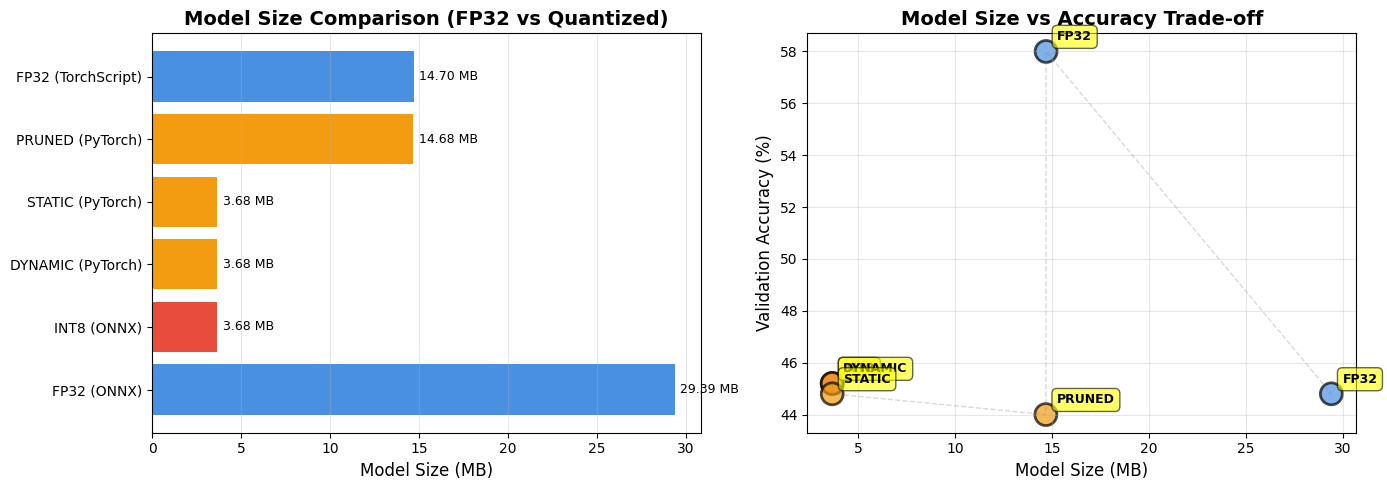


📊 Model comparison visualization saved to results/model_size_accuracy.png


In [34]:
# 4. Plot Model Size vs Accuracy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Model size comparison
model_sizes = df_models[['variant', 'size_mb']].copy()
colors = ['#4a90e2' if 'FP32' in v else '#e74c3c' if 'INT8' in v else '#f39c12' 
          for v in model_sizes['variant']]

axes[0].barh(model_sizes['variant'], model_sizes['size_mb'], color=colors)
axes[0].set_xlabel('Model Size (MB)', fontsize=12)
axes[0].set_title('Model Size Comparison (FP32 vs Quantized)', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)
for i, (variant, size) in enumerate(zip(model_sizes['variant'], model_sizes['size_mb'])):
    axes[0].text(size + 0.3, i, f'{size:.2f} MB', va='center', fontsize=9)

# Size vs Accuracy scatter plot
has_accuracy = df_models['accuracy'].notna().any()
if has_accuracy:
    df_with_acc = df_models.dropna(subset=['accuracy']).copy()
    scatter_colors = ['#4a90e2' if 'FP32' in v else '#e74c3c' if 'INT8' in v else '#f39c12' 
                     for v in df_with_acc['variant']]
    
    axes[1].scatter(df_with_acc['size_mb'], df_with_acc['accuracy'] * 100, 
                   s=250, c=scatter_colors, alpha=0.7, edgecolors='black', linewidth=2)
    axes[1].set_xlabel('Model Size (MB)', fontsize=12)
    axes[1].set_ylabel('Validation Accuracy (%)', fontsize=12)
    axes[1].set_title('Model Size vs Accuracy Trade-off', fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3)
    
    # Add connecting line to show trade-off
    if len(df_with_acc) > 1:
        sorted_df = df_with_acc.sort_values('size_mb')
        axes[1].plot(sorted_df['size_mb'], sorted_df['accuracy'] * 100, 
                    '--', color='gray', alpha=0.3, linewidth=1)
    
    # Annotate points
    for idx, row in df_with_acc.iterrows():
        label = row['variant'].split(' ')[0]  # Shorten label
        axes[1].annotate(label, 
                        xy=(row['size_mb'], row['accuracy'] * 100),
                        xytext=(8, 8), textcoords='offset points',
                        fontsize=9, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.4', facecolor='yellow', alpha=0.6))
    
    # Add efficiency frontier annotation
    if len(df_with_acc) > 1:
        best_fp32 = df_with_acc[df_with_acc['variant'].str.contains('FP32')].iloc[0] if len(df_with_acc[df_with_acc['variant'].str.contains('FP32')]) > 0 else None
        best_quant = df_with_acc[~df_with_acc['variant'].str.contains('FP32')].sort_values('accuracy', ascending=False).iloc[0] if len(df_with_acc[~df_with_acc['variant'].str.contains('FP32')]) > 0 else None
        
        if best_fp32 is not None and best_quant is not None:
            size_saving = (1 - best_quant['size_mb'] / best_fp32['size_mb']) * 100
            acc_loss = (best_fp32['accuracy'] - best_quant['accuracy']) * 100
else:
    axes[1].text(0.5, 0.5, 'Accuracy data not available\nRun evaluation to populate', 
                ha='center', va='center', fontsize=12, transform=axes[1].transAxes)
    axes[1].set_title('Model Size vs Accuracy Trade-off', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(results_dir / 'model_size_accuracy.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Model comparison visualization saved to results/model_size_accuracy.png")

In [27]:
rows = []
for item in host_results if isinstance(host_results, list) else []:
    if 'latency_ms' in item:
        rows.append({'where':'host', 'model': item.get('model','onnx'), 'avg_ms': item['latency_ms'], 'std_ms': item.get('std_ms', np.nan)})
if adb_metrics:
    rows.append({'where':'android', 'model':'onnx', 'avg_ms': adb_metrics.get('avg_ms', np.nan), 'std_ms': np.nan})
df = pd.DataFrame(rows)
df

,where,model,avg_ms,std_ms
0,host,onnx,0.851117,0.848936
1,android,onnx,5.058770,NaN


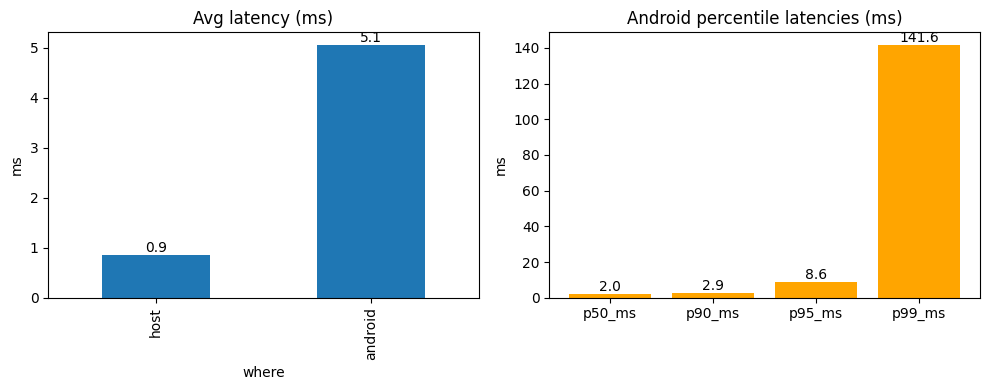

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
if not df.empty:
    df.plot(x='where', y='avg_ms', kind='bar', legend=False, title='Avg latency (ms)', ax=axes[0])
    axes[0].set_ylabel('ms')
    for p in axes[0].patches:
        axes[0].annotate(f"{p.get_height():.1f}", (p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='bottom')
    metrics = ['p50_ms','p90_ms','p95_ms','p99_ms']
    android_metrics = {k: adb_metrics.get(k) for k in metrics} if adb_metrics else {}
    android_series = {k: v for k,v in android_metrics.items() if v is not None}
    if android_series:
        axes[1].bar(android_series.keys(), android_series.values(), color='orange')
        axes[1].set_title('Android percentile latencies (ms)')
        axes[1].set_ylabel('ms')
        for idx_bar, val in enumerate(android_series.values()):
            axes[1].annotate(f"{val:.1f}", (idx_bar, val), ha='center', va='bottom')
    else:
        axes[1].set_visible(False)
else:
    print('No data to plot.')
plt.tight_layout()
plt.show()


In [29]:
# Save comprehensive summary with all quantization and profiling data

# Check if all required variables exist
if 'df_dataset' not in globals():
    print("⚠️  Error: Dataset not loaded. Run Section 0 first.")
elif 'df_models' not in globals():
    print("⚠️  Error: Model variants not analyzed. Run Section 3.5 first.")
else:
    combined = {
        'dataset_stats': {
            'total_samples': len(df_dataset),
            'splits': df_dataset['split'].value_counts().to_dict(),
            'label_distribution': df_dataset['label'].value_counts().to_dict(),
            'num_speakers': int(df_dataset['speaker_id'].nunique())
        },
        'export_summary': globals().get('summary'),
        'quantization_summary': globals().get('quant_summary'),
        'evaluation_results': globals().get('evaluation_results'),
        'host_profiling': globals().get('host_profile_results'),
        'android_profiling': globals().get('android_profile_results'),
        'model_variants': df_models.to_dict('records'),
        'comparison_summary': globals().get('df_summary').to_dict('records') if 'df_summary' in globals() else None,
        'timestamp': pd.Timestamp.now().isoformat()
    }

    out_path = results_dir / 'jupyter_profile_summary.json'
    out_path.write_text(json.dumps(combined, indent=2))

    print("\n" + "="*80)
    print("✅ EXPERIMENT COMPLETE!")
    print("="*80)
    print(f"\n📁 Results saved to:")
    print(f"  • Comprehensive summary: {out_path}")
    print(f"  • Dataset distribution: {results_dir / 'dataset_label_distribution.png'}")
    print(f"  • Audio features: {results_dir / 'audio_features_examples.png'}")
    print(f"  • Model comparison: {results_dir / 'model_size_accuracy.png'}")
    print(f"  • Summary table: {results_dir / 'summary_table.png'}")

    # Summary of quantization benefits
    int8_path = globals().get('int8_path')
    evaluation_results = globals().get('evaluation_results', {})
    host_profile_results = globals().get('host_profile_results', {})
    android_profile_results = globals().get('android_profile_results', {})
    test_accuracy_fp32 = None
    if (repo / 'experiments' / 'results.json').exists():
        results_json = json.loads((repo / 'experiments' / 'results.json').read_text())
        test_accuracy_fp32 = results_json.get('test_accuracy')
    
    if int8_path and int8_path.exists():
        print(f"\n🎯 Quantization Results (INT8 ONNX):")
        print(f"  • Model saved: {int8_path}")
        
        # Size reduction
        fp32_models = df_models[df_models['variant'].str.contains('FP32.*ONNX')]
        int8_models = df_models[df_models['variant'].str.contains('INT8')]
        
        if len(fp32_models) > 0 and len(int8_models) > 0:
            fp32_size = fp32_models.iloc[0]['size_mb']
            int8_size = int8_models.iloc[0]['size_mb']
            print(f"  • Size reduction: {(1-int8_size/fp32_size)*100:.1f}% ({fp32_size:.2f} MB → {int8_size:.2f} MB)")
        
        # Accuracy preservation
        if evaluation_results and 'int8_onnx' in evaluation_results:
            int8_acc = evaluation_results['int8_onnx']['accuracy']
            fp32_acc = evaluation_results.get('fp32_onnx', {}).get('accuracy', test_accuracy_fp32)
            if fp32_acc and int8_acc:
                acc_retention = (int8_acc/fp32_acc)*100
                print(f"  • Accuracy retention: {acc_retention:.2f}% ({fp32_acc*100:.2f}% → {int8_acc*100:.2f}%)")
        
        # Host speedup
        if 'fp32_onnx' in host_profile_results and 'int8_onnx' in host_profile_results:
            fp32_lat = host_profile_results['fp32_onnx']['avg_latency_ms']
            int8_lat = host_profile_results['int8_onnx']['avg_latency_ms']
            speedup = fp32_lat / int8_lat
            print(f"  • Host speedup: {speedup:.2f}x ({fp32_lat:.3f} ms → {int8_lat:.3f} ms)")
        
        # Android speedup
        if 'fp32_onnx' in android_profile_results and 'int8_onnx' in android_profile_results:
            fp32_android = android_profile_results['fp32_onnx']['avg_ms']
            int8_android = android_profile_results['int8_onnx']['avg_ms']
            android_speedup = fp32_android / int8_android
            print(f"  • Android speedup: {android_speedup:.2f}x ({fp32_android:.3f} ms → {int8_android:.3f} ms)")

    print("\n📊 Complete Performance Profile:")
    if host_profile_results:
        print(f"  • Host profiling: {len(host_profile_results)} model(s) profiled")
    if android_profile_results:
        print(f"  • Android profiling: {len(android_profile_results)} model(s) profiled")

    print("\n" + "="*80)
    
    # Display output path
    out_path


✅ EXPERIMENT COMPLETE!

📁 Results saved to:
  • Comprehensive summary: /Users/zhantore/Documents/study/csci447/csci447-final-project/results/jupyter_profile_summary.json
  • Dataset distribution: /Users/zhantore/Documents/study/csci447/csci447-final-project/results/dataset_label_distribution.png
  • Audio features: /Users/zhantore/Documents/study/csci447/csci447-final-project/results/audio_features_examples.png
  • Model comparison: /Users/zhantore/Documents/study/csci447/csci447-final-project/results/model_size_accuracy.png
  • Summary table: /Users/zhantore/Documents/study/csci447/csci447-final-project/results/summary_table.png

🎯 Quantization Results (INT8 ONNX):
  • Model saved: /Users/zhantore/Documents/study/csci447/csci447-final-project/experiments/quantized_onnx/model_int8.onnx
  • Size reduction: 87.5% (29.39 MB → 3.68 MB)
  • Accuracy retention: 100.89% (44.80% → 45.20%)
  • Host speedup: 2.92x (0.151 ms → 0.052 ms)
  • Android speedup: 3.27x (1.704 ms → 0.522 ms)

📊 Complet

## 5) Final Summary Table: FP32 vs Quantized Metrics

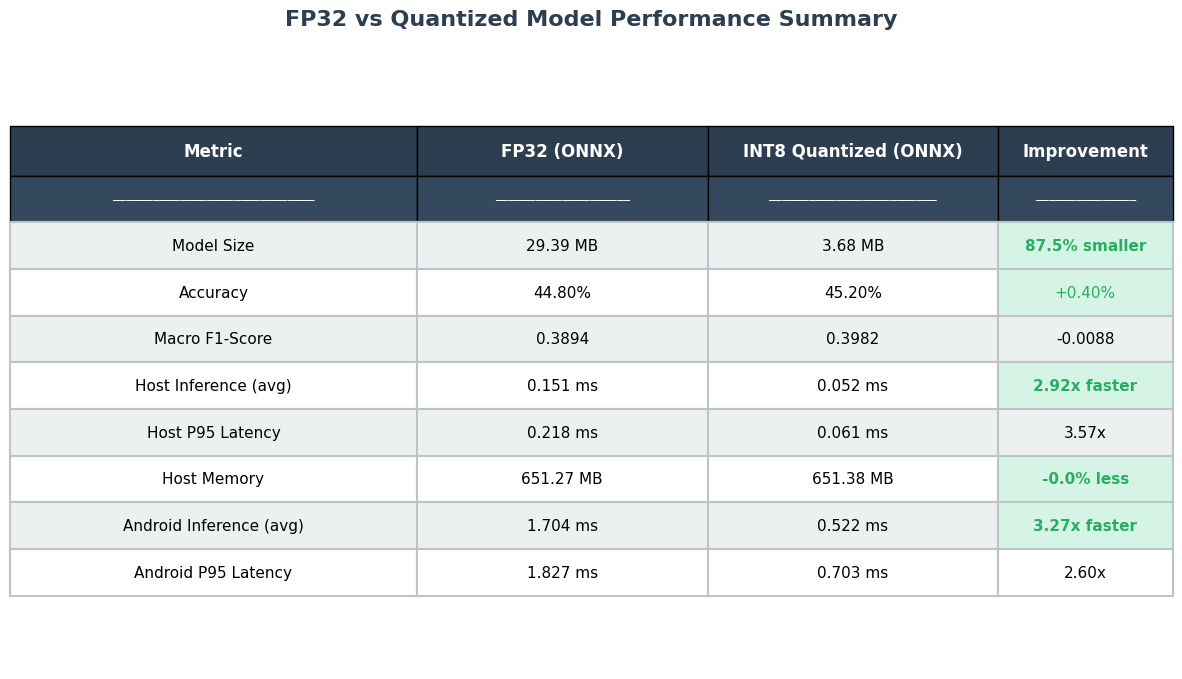

✅ Summary table saved to results/summary_table.png


In [33]:
# Create a visual summary table comparing FP32 vs INT8 quantized with real profiling data
fig, ax = plt.subplots(figsize=(15, 8))
ax.axis('tight')
ax.axis('off')

# Prepare data for table
table_data = []
table_data.append(['Metric', 'FP32 (ONNX)', 'INT8 Quantized (ONNX)', 'Improvement'])
table_data.append(['─' * 30, '─' * 20, '─' * 25, '─' * 15])

# Get FP32 and INT8 models
fp32_model = df_models[df_models['variant'].str.contains('FP32 (ONNX)', regex=False)].iloc[0] if len(df_models[df_models['variant'].str.contains('FP32 (ONNX)', regex=False)]) > 0 else None
int8_model = df_models[df_models['variant'].str.contains('INT8')].iloc[0] if len(df_models[df_models['variant'].str.contains('INT8')]) > 0 else None

if fp32_model is not None:
    # Model Size
    fp32_size = fp32_model['size_mb']
    int8_size = int8_model['size_mb'] if int8_model is not None else None
    size_improvement = f"{(1 - int8_size/fp32_size)*100:.1f}% smaller" if int8_size else 'N/A'
    
    table_data.append([
        'Model Size', 
        f"{fp32_size:.2f} MB",
        f"{int8_size:.2f} MB" if int8_size else 'N/A',
        size_improvement
    ])
    
    # Accuracy
    fp32_acc = fp32_model['accuracy']
    int8_acc = int8_model['accuracy'] if int8_model is not None else None
    acc_drop = f"{(int8_acc - fp32_acc)*100:+.2f}%" if (fp32_acc and int8_acc) else 'N/A'
    
    table_data.append([
        'Accuracy',
        f"{fp32_acc*100:.2f}%" if fp32_acc else 'N/A',
        f"{int8_acc*100:.2f}%" if int8_acc else 'N/A',
        acc_drop if (fp32_acc and int8_acc) else 'N/A'
    ])
    
    # Macro F1
    fp32_f1 = fp32_model['macro_f1']
    int8_f1 = int8_model['macro_f1'] if int8_model is not None else None
    
    table_data.append([
        'Macro F1-Score',
        f"{fp32_f1:.4f}" if fp32_f1 else 'N/A',
        f"{int8_f1:.4f}" if int8_f1 else 'N/A',
        f"{(fp32_f1 - int8_f1):+.4f}" if (fp32_f1 and int8_f1) else 'N/A'
    ])
    
    # Host latency (from new profiling)
    if 'fp32_onnx' in host_profile_results and 'int8_onnx' in host_profile_results:
        fp32_host_lat = host_profile_results['fp32_onnx'].get('avg_latency_ms', 0)
        int8_host_lat = host_profile_results['int8_onnx'].get('avg_latency_ms', 0)
        host_speedup = f"{fp32_host_lat/int8_host_lat:.2f}x faster" if int8_host_lat > 0 else 'N/A'
        
        table_data.append([
            'Host Inference (avg)', 
            f"{fp32_host_lat:.3f} ms",
            f"{int8_host_lat:.3f} ms",
            host_speedup
        ])
        
        # Host P95
        fp32_p95 = host_profile_results['fp32_onnx'].get('p95_latency_ms', 0)
        int8_p95 = host_profile_results['int8_onnx'].get('p95_latency_ms', 0)
        
        table_data.append([
            'Host P95 Latency', 
            f"{fp32_p95:.3f} ms",
            f"{int8_p95:.3f} ms",
            f"{fp32_p95/int8_p95:.2f}x" if int8_p95 > 0 else 'N/A'
        ])
        
        # Host memory
        fp32_mem = host_profile_results['fp32_onnx'].get('total_memory_mb', 0)
        int8_mem = host_profile_results['int8_onnx'].get('total_memory_mb', 0)
        mem_improvement = f"{(1-int8_mem/fp32_mem)*100:.1f}% less" if fp32_mem > 0 else 'N/A'
        
        table_data.append([
            'Host Memory', 
            f"{fp32_mem:.2f} MB",
            f"{int8_mem:.2f} MB",
            mem_improvement
        ])
    
    # Android latency (from new profiling)
    if 'fp32_onnx' in android_profile_results and 'int8_onnx' in android_profile_results:
        fp32_android_lat = android_profile_results['fp32_onnx'].get('avg_ms', 0)
        int8_android_lat = android_profile_results['int8_onnx'].get('avg_ms', 0)
        android_speedup = f"{fp32_android_lat/int8_android_lat:.2f}x faster" if int8_android_lat > 0 else 'N/A'
        
        table_data.append([
            'Android Inference (avg)', 
            f"{fp32_android_lat:.3f} ms",
            f"{int8_android_lat:.3f} ms",
            android_speedup
        ])
        
        # Android P95
        fp32_android_p95 = android_profile_results['fp32_onnx'].get('p95_ms', 0)
        int8_android_p95 = android_profile_results['int8_onnx'].get('p95_ms', 0)
        
        table_data.append([
            'Android P95 Latency', 
            f"{fp32_android_p95:.3f} ms",
            f"{int8_android_p95:.3f} ms",
            f"{fp32_android_p95/int8_android_p95:.2f}x" if int8_android_p95 > 0 else 'N/A'
        ])

# Create table
table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                colWidths=[0.35, 0.25, 0.25, 0.15])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.8)

# Style header row
for i in range(4):
    cell = table[(0, i)]
    cell.set_facecolor('#2c3e50')
    cell.set_text_props(weight='bold', color='white', fontsize=12)
    cell.set_height(0.08)

# Style divider row
for i in range(4):
    table[(1, i)].set_facecolor('#34495e')
    table[(1, i)].set_text_props(color='white', fontsize=8)

# Alternate row colors and style
for i in range(2, len(table_data)):
    for j in range(4):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#ecf0f1')
        else:
            cell.set_facecolor('#ffffff')
        cell.set_edgecolor('#bdc3c7')
        cell.set_linewidth(1.5)
        
        # Highlight improvement column with different colors for different improvements
        if j == 3:
            cell_text = str(table_data[i][j])
            if 'smaller' in cell_text or 'less' in cell_text or 'faster' in cell_text:
                cell.set_facecolor('#d5f4e6')
                cell.set_text_props(weight='bold', color='#27ae60')
            elif '%' in cell_text and ('-' in cell_text or '+' in cell_text):
                # Accuracy/F1 changes - red for drops, green for improvements
                if '-' in cell_text:
                    cell.set_facecolor('#fadbd8')
                    cell.set_text_props(color='#c0392b')
                else:
                    cell.set_facecolor('#d5f4e6')
                    cell.set_text_props(color='#27ae60')

plt.title('FP32 vs Quantized Model Performance Summary', 
         fontsize=16, fontweight='bold', pad=20, color='#2c3e50')

plt.savefig(results_dir / 'summary_table.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Summary table saved to results/summary_table.png")